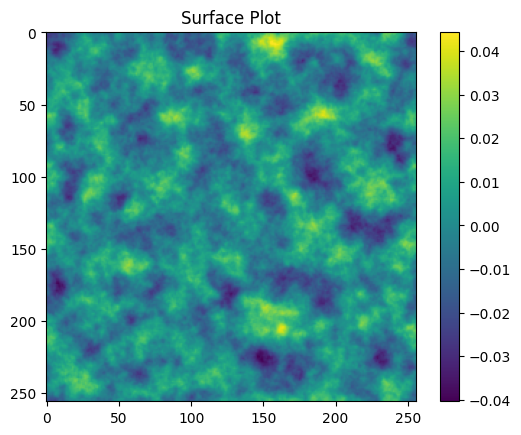

 Iter          Cost_f           Error
    0   -1.486683e+01    2.592367e+00
   64   -2.611926e+01    7.140546e-13
 Iter          Cost_f           Error
    0   -1.910011e+01    4.687500e-02
   50   -2.555832e+01    8.283924e-13
 Iter          Cost_f           Error
    0   -1.877620e+01    3.116974e-02
   46   -2.517617e+01    6.782872e-13
 Iter          Cost_f           Error
    0   -1.853745e+01    2.377768e-02
   48   -2.489515e+01    5.589169e-13
 Iter          Cost_f           Error
    0   -1.835187e+01    1.813688e-02
   47   -2.467561e+01    9.512591e-13
 Iter          Cost_f           Error
    0   -1.820041e+01    1.530312e-02
   48   -2.449635e+01    8.584936e-13
 Iter          Cost_f           Error
    0   -1.807307e+01    1.259459e-02
   47   -2.434499e+01    6.383862e-13
 Iter          Cost_f           Error
    0   -1.796291e+01    1.068381e-02
   46   -2.421388e+01    9.864838e-13
 Iter          Cost_f           Error
    0   -1.786574e+01    9.270329e-03
   46   -2.4

Execution time: 20.187160077970475
Fitted beta: 0.0003178555842041189
Covariance matrix: [[1.62670332e-11 5.51021200e-07]
 [5.51021200e-07 1.88077755e-02]]
Contact area percentage: 0.041046142578125


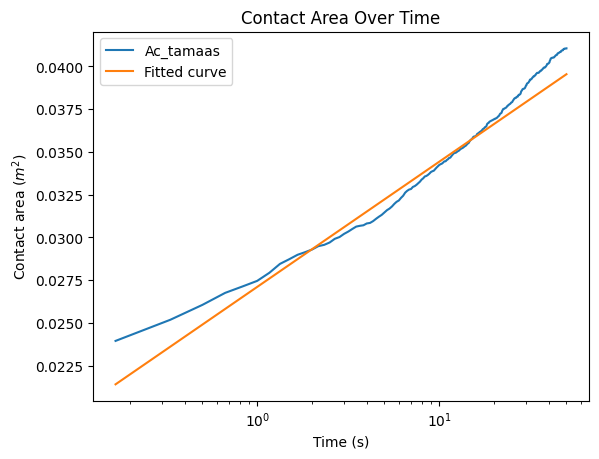

In [1]:
import tamaas as tm
import tamaas.utils
import matplotlib.pyplot as plt
import numpy as np
import time

# Parallel computation
tm.initialize(8)

# Initialize threads and fftw
tm.set_log_level(tm.LogLevel.info)  # Show progression of solver

# Discretization
n = 256

# Generating surface
try:
    surface = np.load("more_rough_surface.npy")
except FileNotFoundError:
    print("Error: 'surface.npy' not found. Make sure the file exists in the working directory.")
    surface = np.random.rand(n, n)  # For testing, replace with actual surface data

plt.imshow(surface)
plt.title("Surface Plot")
plt.colorbar()
plt.show()

# Domain size
L = 1.0

model = tm.Model(tm.model_type.basic_2d, [L, L], [n, n])
model.E = 3
model.nu = 0.5

shear_modulus = [3] * 50
characteristic_time = np.logspace(-1, 9, 50)

# Time
t0 = 0
t1 = 50
time_steps = 300
dt = (t1 - t0) / time_steps

# Const loading
W = 5e0

# Solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

solver.reset()

Ac_tamaas = []

# Solve for target pressure
p_target =  W / (L**2)  # Average pressure

# Reset the solver to avoid history accumulation
solver.reset()

start_time = time.perf_counter()

for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas.append(tm.Statistics2D.contact(model.traction))


end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time)
np.save("Ac_tamaas.npy", Ac_tamaas)

# Curve fitting to get \beta
from scipy.optimize import curve_fit

Ac_tamaas = np.load("Ac_tamaas.npy")
origin_contact_area = np.load("Ac_tamaas.npy")

# Define the target function
def target_func(t, beta, t_star):
    return beta * (t - t_star) / np.min(characteristic_time)

# Extract the relevant data
x_data_1 = np.arange(t0, t1, dt)[:150] + dt
x_data_1 = np.log(x_data_1)
y_data_1 = origin_contact_area[:150]

# Perform the curve fitting
popt_1, pcov_1 = curve_fit(target_func, x_data_1, y_data_1, p0=(1, np.min(characteristic_time)))

# Extract the fitted parameters
beta_1_fit, t_star_1_fit = popt_1

# Print the fitted parameter
print("Fitted beta:", beta_1_fit)
print("Covariance matrix:", pcov_1)
print("Contact area percentage:", np.max(Ac_tamaas) / L**2)

# Plotting
plt.plot(np.arange(t0, t1, dt) + dt, Ac_tamaas, label="Ac_tamaas")
plt.plot(np.arange(t0, t1, dt) + dt, target_func(np.log(np.arange(t0, t1, dt) + dt), beta_1_fit, t_star_1_fit), label="Fitted curve")
plt.xlabel("Time (s)")
plt.ylabel("Contact area ($m^2$)")
plt.xscale("log")
plt.legend()
plt.title("Contact Area Over Time")
plt.show()


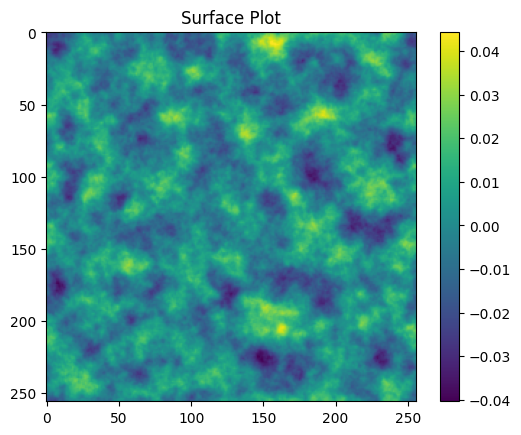

 Iter          Cost_f           Error
    0   -6.188236e+00    2.579626e+00
   54   -1.265845e+01    7.234758e-13
 Iter          Cost_f           Error
    0   -9.211518e+00    2.645770e-02
   41   -1.251723e+01    9.481191e-13
 Iter          Cost_f           Error
    0   -9.131726e+00    1.732165e-02
   41   -1.242326e+01    9.135321e-13
 Iter          Cost_f           Error
    0   -9.073838e+00    1.245551e-02
   43   -1.235509e+01    8.199624e-13
 Iter          Cost_f           Error
    0   -9.028994e+00    9.476901e-03
   41   -1.230242e+01    7.038927e-13
 Iter          Cost_f           Error
    0   -8.992714e+00    7.586429e-03
   39   -1.225973e+01    6.013876e-13
 Iter          Cost_f           Error
    0   -8.962297e+00    6.407484e-03
   38   -1.222391e+01    5.967221e-13
 Iter          Cost_f           Error
    0   -8.936042e+00    5.447059e-03
   38   -1.219307e+01    9.206556e-13
 Iter          Cost_f           Error
    0   -8.912984e+00    5.121509e-03
   35   -1.2

Execution time for W=2.0: 16.513732304796576
Fitted beta for W=2.0: 5.532560235665006e-05
Covariance matrix for W=2.0: [[2.16359578e-13 8.06424155e-08]
 [8.06424155e-08 3.01200416e-02]]
Contact area percentage for W=2.0: 0.0125732421875


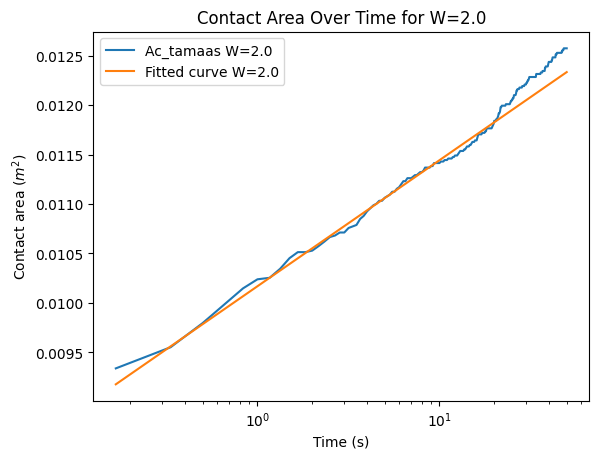

 Iter          Cost_f           Error
    0   -2.381790e+01    8.581262e-01
   67   -3.952674e+01    7.543399e-13
 Iter          Cost_f           Error
    0   -2.952232e+01    2.999805e-02
   51   -3.895789e+01    8.692222e-13
 Iter          Cost_f           Error
    0   -2.919873e+01    2.026036e-02
   51   -3.857800e+01    7.215763e-13
 Iter          Cost_f           Error
    0   -2.896433e+01    1.448542e-02
   49   -3.830204e+01    6.089015e-13
 Iter          Cost_f           Error
    0   -2.878294e+01    1.169117e-02
   48   -3.808829e+01    7.231361e-13
 Iter          Cost_f           Error
    0   -2.863603e+01    9.357551e-03
   49   -3.791487e+01    5.034953e-13
 Iter          Cost_f           Error
    0   -2.851296e+01    7.777243e-03
   48   -3.776921e+01    4.970552e-13
 Iter          Cost_f           Error
    0   -2.840706e+01    6.745939e-03
   47   -3.764367e+01    7.557663e-13
 Iter          Cost_f           Error
    0   -2.831415e+01    5.845747e-03
   46   -3.7

Execution time for W=8.0: 19.336144824977964
Fitted beta for W=8.0: 0.00020995797392372366
Covariance matrix for W=8.0: [[1.15133417e-12 1.15688658e-07]
 [1.15688658e-07 1.16478161e-02]]
Contact area percentage for W=8.0: 0.0482025146484375


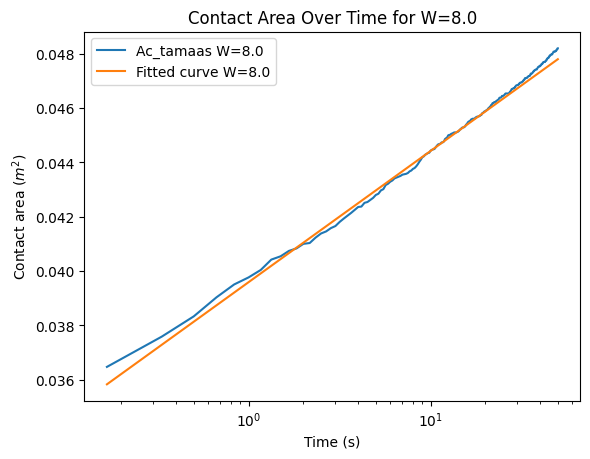

 Iter          Cost_f           Error
    0   -5.135073e+01    4.331464e-01
   73   -6.768402e+01    8.397052e-13
 Iter          Cost_f           Error
    0   -5.180846e+01    3.246325e-02
   61   -6.649158e+01    5.869444e-13
 Iter          Cost_f           Error
    0   -5.112936e+01    2.286992e-02
   58   -6.569456e+01    8.104902e-13
 Iter          Cost_f           Error
    0   -5.063722e+01    1.638129e-02
   57   -6.511529e+01    8.055383e-13
 Iter          Cost_f           Error
    0   -5.025735e+01    1.253721e-02
   59   -6.466662e+01    7.796686e-13
 Iter          Cost_f           Error
    0   -4.994960e+01    1.047843e-02
   56   -6.430231e+01    8.044583e-13
 Iter          Cost_f           Error
    0   -4.969152e+01    8.703028e-03
   54   -6.399608e+01    9.334121e-13
 Iter          Cost_f           Error
    0   -4.946943e+01    7.465447e-03
   55   -6.373206e+01    8.816238e-13
 Iter          Cost_f           Error
    0   -4.927454e+01    6.559968e-03
   54   -6.3

Execution time for W=16.0: 24.399795908946544
Fitted beta for W=16.0: 0.00041381814209856576
Covariance matrix for W=16.0: [[8.39279320e-12 4.20630964e-07]
 [4.20630964e-07 2.11246872e-02]]
Contact area percentage for W=16.0: 0.09381103515625


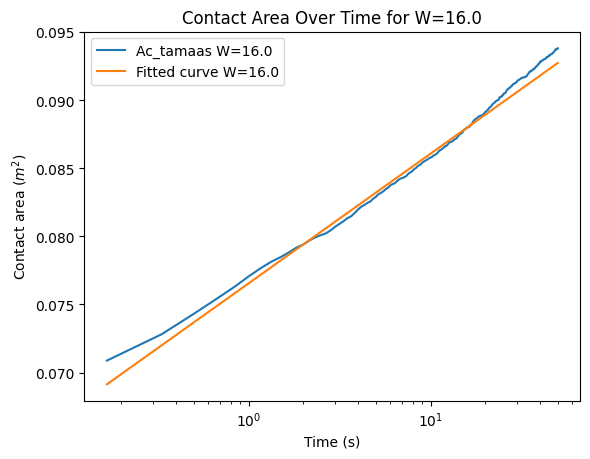

 Iter          Cost_f           Error
    0   -7.273635e+01    1.305968e-01
   82   -9.114646e+01    5.411988e-13
 Iter          Cost_f           Error
    0   -7.114288e+01    3.761589e-02
   68   -8.929600e+01    6.691121e-13
 Iter          Cost_f           Error
    0   -7.008346e+01    2.489836e-02
   65   -8.805951e+01    9.095840e-13
 Iter          Cost_f           Error
    0   -6.931721e+01    1.816578e-02
   71   -8.716137e+01    8.638040e-13
 Iter          Cost_f           Error
    0   -6.872601e+01    1.398055e-02
   69   -8.646578e+01    6.145848e-13
 Iter          Cost_f           Error
    0   -6.824747e+01    1.117669e-02
   62   -8.590103e+01    5.944052e-13
 Iter          Cost_f           Error
    0   -6.784651e+01    9.332241e-03
   65   -8.542632e+01    9.172221e-13
 Iter          Cost_f           Error
    0   -6.750148e+01    8.036561e-03
   69   -8.501690e+01    8.190121e-13
 Iter          Cost_f           Error
    0   -6.719842e+01    6.983539e-03
   61   -8.4

Execution time for W=24.0: 27.18742177914828
Fitted beta for W=24.0: 0.0005936515656875463
Covariance matrix for W=24.0: [[1.68405875e-11 5.95661629e-07]
 [5.95661629e-07 2.11112778e-02]]
Contact area percentage for W=24.0: 0.1361083984375


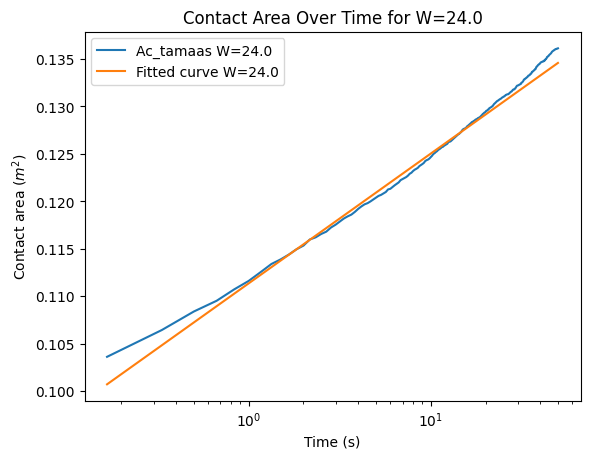

 Iter          Cost_f           Error
    0   -9.041382e+01    3.311693e-02
   72   -1.114118e+02    9.000076e-13
 Iter          Cost_f           Error
    0   -8.842138e+01    3.954174e-02
   80   -1.088886e+02    6.941321e-13
 Iter          Cost_f           Error
    0   -8.696828e+01    2.692675e-02
   77   -1.072021e+02    7.268758e-13
 Iter          Cost_f           Error
    0   -8.591662e+01    2.035808e-02
   74   -1.059769e+02    9.764037e-13
 Iter          Cost_f           Error
    0   -8.510602e+01    1.553128e-02
   70   -1.050279e+02    7.838188e-13
 Iter          Cost_f           Error
    0   -8.444887e+01    1.246489e-02
   74   -1.042571e+02    7.136850e-13
 Iter          Cost_f           Error
    0   -8.389794e+01    1.081203e-02
   73   -1.036094e+02    9.499499e-13
 Iter          Cost_f           Error
    0   -8.342420e+01    9.188702e-03
   70   -1.030511e+02    7.597747e-13
 Iter          Cost_f           Error
    0   -8.300879e+01    7.993906e-03
   66   -1.0

Execution time for W=32.0: 27.80545086786151
Fitted beta for W=32.0: 0.0007210246525268954
Covariance matrix for W=32.0: [[5.57438453e-12 1.73780149e-07]
 [1.73780149e-07 5.42706349e-03]]
Contact area percentage for W=32.0: 0.175506591796875


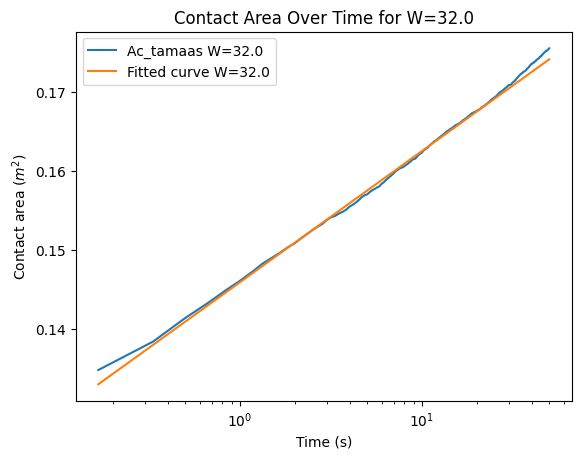

 Iter          Cost_f           Error
    0   -1.216664e+02    1.577873e-01
  100   -1.213834e+02    8.580089e-10
  120   -1.450321e+02    9.194646e-13
 Iter          Cost_f           Error
    0   -1.182016e+02    4.571409e-02
  100   -1.180442e+02    8.895623e-12
  107   -1.411459e+02    9.553901e-13
 Iter          Cost_f           Error
    0   -1.159313e+02    3.221811e-02
   88   -1.385541e+02    5.548187e-13
 Iter          Cost_f           Error
    0   -1.142923e+02    2.353408e-02
   80   -1.366754e+02    9.474968e-13
 Iter          Cost_f           Error
    0   -1.130307e+02    1.804270e-02
   86   -1.352230e+02    8.079755e-13
 Iter          Cost_f           Error
    0   -1.120120e+02    1.515817e-02
   82   -1.340453e+02    8.462795e-13
 Iter          Cost_f           Error
    0   -1.111590e+02    1.260122e-02
   77   -1.330564e+02    9.557104e-13
 Iter          Cost_f           Error
    0   -1.104252e+02    1.087447e-02
   78   -1.322045e+02    8.339653e-13
 Iter       

Execution time for W=48.0: 29.911058821249753
Fitted beta for W=48.0: 0.0010256930551060305
Covariance matrix for W=48.0: [[2.36244303e-11 5.20556439e-07]
 [5.20556439e-07 1.14901986e-02]]
Contact area percentage for W=48.0: 0.2515869140625


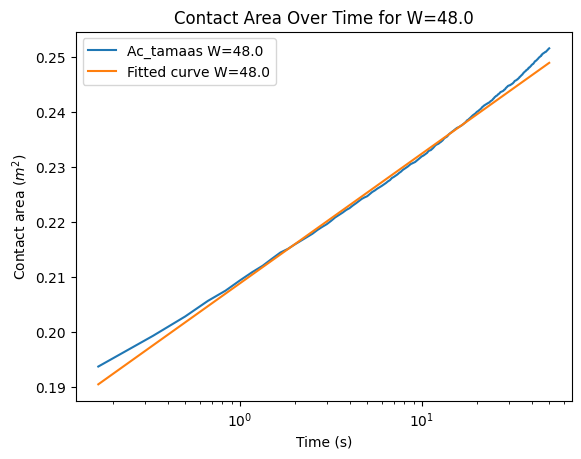

 Iter          Cost_f           Error
    0   -1.471271e+02    3.800360e-02
  100   -1.472545e+02    4.236462e-10
  119   -1.719142e+02    9.553600e-13
 Iter          Cost_f           Error
    0   -1.429632e+02    5.124208e-02
  100   -1.427556e+02    3.169110e-10
  119   -1.667358e+02    8.042772e-13
 Iter          Cost_f           Error
    0   -1.399101e+02    3.400980e-02
   97   -1.632891e+02    9.908023e-13
 Iter          Cost_f           Error
    0   -1.377099e+02    2.453089e-02
  100   -1.376002e+02    5.185428e-12
  106   -1.607943e+02    8.555403e-13
 Iter          Cost_f           Error
    0   -1.360177e+02    1.903317e-02
   88   -1.588680e+02    8.852770e-13
 Iter          Cost_f           Error
    0   -1.346521e+02    1.527196e-02
   97   -1.573076e+02    9.414208e-13
 Iter          Cost_f           Error
    0   -1.335087e+02    1.362925e-02
  100   -1.334495e+02    1.992104e-11
  111   -1.559985e+02    6.941306e-13
 Iter          Cost_f           Error
    0   -1.3

Execution time for W=64.0: 32.45405064802617
Fitted beta for W=64.0: 0.0013101930654493069
Covariance matrix for W=64.0: [[3.28761624e-11 5.69659526e-07]
 [5.69659526e-07 9.88771936e-03]]
Contact area percentage for W=64.0: 0.32171630859375


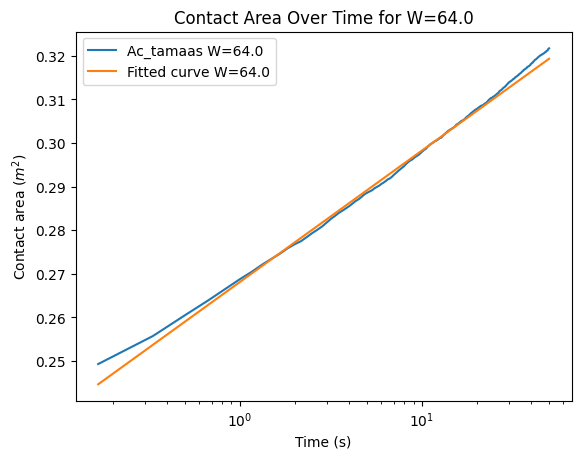

All execution times: [16.513732304796576, 19.336144824977964, 24.399795908946544, 27.18742177914828, 27.80545086786151, 29.911058821249753, 32.45405064802617]
All beta values: [np.float64(5.532560235665006e-05), np.float64(0.00020995797392372366), np.float64(0.00041381814209856576), np.float64(0.0005936515656875463), np.float64(0.0007210246525268954), np.float64(0.0010256930551060305), np.float64(0.0013101930654493069)]


In [2]:
import tamaas as tm
import tamaas.utils
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.optimize import curve_fit

# Parallel computation
tm.initialize(8)

# Initialize threads and fftw
tm.set_log_level(tm.LogLevel.info)  # Show progression of solver

# Discretization
n = 256

# Generating surface
try:
    surface = np.load("more_rough_surface.npy")
except FileNotFoundError:
    print("Error: 'surface.npy' not found. Make sure the file exists in the working directory.")
    surface = np.random.rand(n, n)  # For testing, replace with actual surface data

plt.imshow(surface)
plt.title("Surface Plot")
plt.colorbar()
plt.show()

# Domain size
L = 1.0

model = tm.Model(tm.model_type.basic_2d, [L, L], [n, n])
model.E = 3
model.nu = 0.5

shear_modulus = [3] * 50
characteristic_time = np.logspace(-1, 9, 50)

# Time
t0 = 0
t1 = 50
time_steps = 300
dt = (t1 - t0) / time_steps

# Loading conditions
W_list = [2e0, 8e0, 16e0, 24e0, 32e0, 48e0, 64e0]

# Solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

beta_values = []
execution_times = []

# Function for curve fitting
def target_func(t, beta, t_star):
    return beta * (t - t_star) / np.min(characteristic_time)

for W in W_list:
    solver.reset()
    Ac_tamaas = []
    p_target = W / (L**2)  # Average pressure

    start_time = time.perf_counter()

    for t in np.linspace(t0, t1, time_steps):
        solver.solve(p_target)
        Ac_tamaas.append(tm.Statistics2D.contact(model.traction))

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times.append(execution_time)
    print(f"Execution time for W={W}:", execution_time)
    np.save(f"Ac_tamaas_W{W}.npy", Ac_tamaas)

    # Curve fitting to get \beta
    origin_contact_area = np.array(Ac_tamaas)

    # Extract the relevant data
    x_data_1 = np.arange(t0, t1, dt)[:150] + dt
    x_data_1 = np.log(x_data_1)
    y_data_1 = origin_contact_area[:150]

    # Perform the curve fitting
    popt_1, pcov_1 = curve_fit(target_func, x_data_1, y_data_1, p0=(1, np.min(characteristic_time)))

    # Extract the fitted parameters
    beta_1_fit, t_star_1_fit = popt_1
    beta_values.append(beta_1_fit)

    # Print the fitted parameter
    print(f"Fitted beta for W={W}:", beta_1_fit)
    print(f"Covariance matrix for W={W}:", pcov_1)
    print(f"Contact area percentage for W={W}:", np.max(Ac_tamaas) / L**2)

    # Plotting
    plt.plot(np.arange(t0, t1, dt) + dt, Ac_tamaas, label=f"Ac_tamaas W={W}")
    plt.plot(np.arange(t0, t1, dt) + dt, target_func(np.log(np.arange(t0, t1, dt) + dt), beta_1_fit, t_star_1_fit), label=f"Fitted curve W={W}")
    plt.xlabel("Time (s)")
    plt.ylabel("Contact area ($m^2$)")
    plt.xscale("log")
    plt.legend()
    plt.title(f"Contact Area Over Time for W={W}")
    plt.show()

# Print all results
print("All execution times:", execution_times)
print("All beta values:", beta_values)


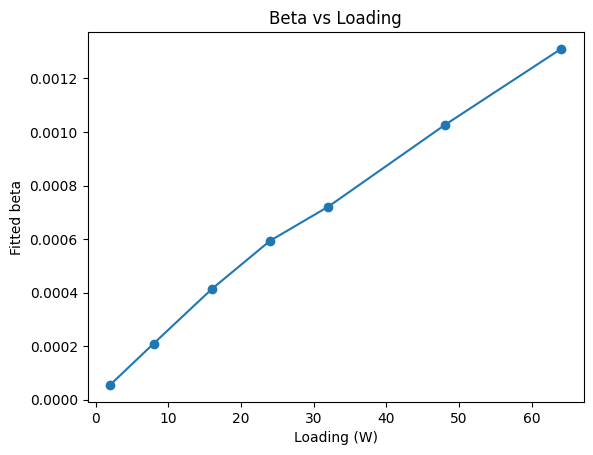

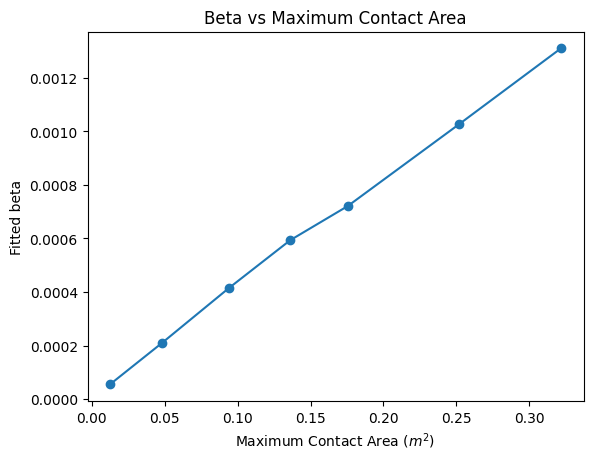

In [3]:
# Plot beta values vs loading conditions
plt.figure()
plt.plot(W_list, beta_values, 'o-')
plt.xlabel("Loading (W)")
plt.ylabel("Fitted beta")
plt.title("Beta vs Loading")

plt.show()



# Plot beta values vs maximum contact area
contact_area_list = [np.max(np.load(f"Ac_tamaas_W{W}.npy")) for W in W_list]    

plt.figure()
plt.plot(contact_area_list, beta_values, 'o-')
plt.xlabel("Maximum Contact Area ($m^2$)")
plt.ylabel("Fitted beta")
plt.title("Beta vs Maximum Contact Area")

plt.show()

Text(0.5, 1.0, 'loading vs Maximum Contact Area')

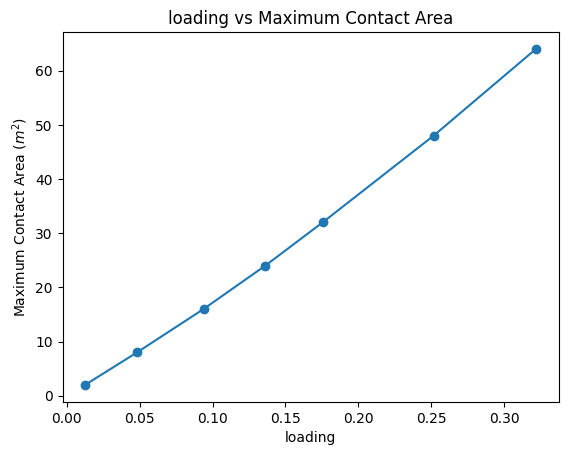

In [4]:
plt.figure()
plt.plot(contact_area_list, W_list, 'o-')
plt.ylabel("Maximum Contact Area ($m^2$)")
plt.xlabel("loading")
plt.title("loading vs Maximum Contact Area")